# Sensitivity Analysis using SOBOL

Group 11, *EPA1361 Model-based Decision-making 18/19*

A. Werntges, H. Cheng, G. Papazotos, R. Patel, P. De Biase

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

import statsmodels.api as sm
import statsmodels.formula.api as smf
from SALib.analyze import sobol

from model.problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

## Over scenarios using zero policy as baseline

We perform sobol sampling over levers for 1,000 sampled scenarios with zero policy as baseline.

In [3]:
# with no policies
ref_policy = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}

policy0 = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    policy0.update({key.name: ref_policy[s]})                

policy0 = Policy('Policy 0', **policy0)

In [ ]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=policy0,
                                            uncertainty_sampling ='sobol')

save_results(results, './results/sobol_policy0_1000scenarios_2steps.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 38000 scenarios * 1 policies * 1 model(s) = 38000 experiments
[MainProcess/INFO] 3800 cases completed
[MainProcess/INFO] 7600 cases completed
[MainProcess/INFO] 11400 cases completed
[MainProcess/INFO] 15200 cases completed
[MainProcess/INFO] 19000 cases completed
[MainProcess/INFO] 22800 cases completed
[MainProcess/INFO] 26600 cases completed


In [4]:
results = load_results('./results/sobol_policy0_1000scenarios_2steps.tar.gz')

_, outcomes_overU = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\sobol_policy0_1000scenarios_2steps.tar.gz


## Over levers using *mean-of-distribution* scenario as baseline

We perform sobol sampling over uncertainties for 1,000 sampled levers with "mean-of-distribution" scenario as baseline. We take the mean values for each uncertainty factor as the "mean-of-distribution" scenario.

In [5]:
# with "mean-of-distribution" scenario
ref_scenario = {'Bmax': 190, 'Brate': 1, 'pfail': 0.5,
                'ID flood wave shape': 4,
                'discount rate': 3.5} # use mean value of the parameter range

scenario0 = {}
for key in dike_model.uncertainties:
    if 'discount rate' in key.name:
        scenario0.update({key.name: ref_scenario['discount rate']})
    else:
        _, s = key.name.split('_') # remove the prefix "A.#_"
        scenario0.update({key.name: ref_scenario[s]}) 

scenario0 = Policy('Scenario 0', **scenario0)

In [ ]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=scenario0, policies=1000,
                                            levers_sampling ='sobol')

save_results(results, './results/sobol_scenario0_1000scenarios_2steps.tar.gz')

In [6]:
results = load_results('./results/sobol_scenario0_1000scenarios_2steps.tar.gz')

_, outcomes_overL = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\sobol_scenario0_1000scenarios_2steps.tar.gz


## SOBOL Analysis

We perform SOBOL analysis for outcomes of Expected Annual Damage and Expected Number of Deaths.

In [7]:
def plot_sobol(problem, outcomes, KPI, ax):
    Si = sobol.analyze(problem, outcomes[KPI], 
                       calc_second_order=True, print_to_console=False)
    scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf',
                                         'S1', 'S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])
    
    indices = Si_df.filter(regex='^((?!conf).)*$')
    err = Si_df.filter(regex='conf$')
    
    indices.plot.bar(yerr=err.values.T, ax=ax)

In [9]:
# get problem of sobol analysis format
problem_overU = get_SALib_problem(dike_model.uncertainties)
problem_overL = get_SALib_problem(dike_model.levers)

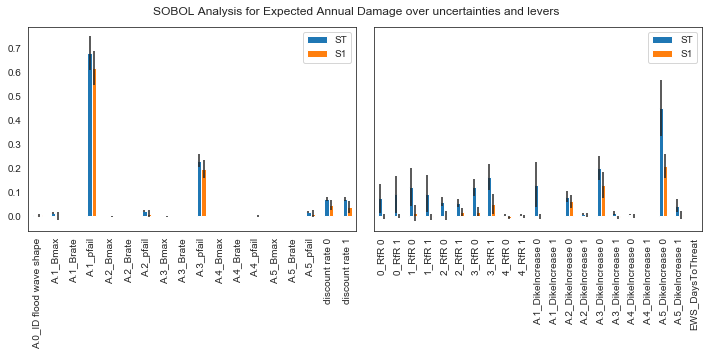

In [10]:
KPI = 'Expected Annual Damage'

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
plot_sobol(problem_overU, outcomes_overU, KPI, ax=axes[0])
plot_sobol(problem_overL, outcomes_overL, KPI, ax=axes[1])
plt.subplots_adjust(wspace=0.02, top=0.18)
fig.suptitle('SOBOL Analysis for {} over uncertainties and levers'.format(KPI))
fig.tight_layout()

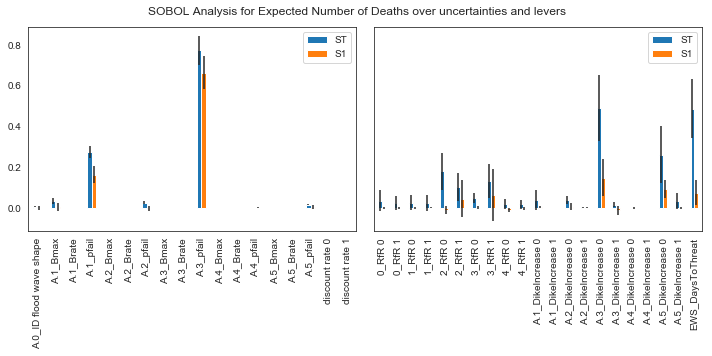

In [11]:
KPI = 'Expected Number of Deaths'

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
plot_sobol(problem_overU, outcomes_overU, KPI, ax=axes[0])
plot_sobol(problem_overL, outcomes_overL, KPI, ax=axes[1])
plt.subplots_adjust(wspace=0.02, top=0.18)
fig.suptitle('SOBOL Analysis for {} over uncertainties and levers'.format(KPI))
fig.tight_layout()